# Iterative Null Space projection

A base implementation using the debias function from https://github.com/shauli-ravfogel/nullspace_projection/tree/master/src. 

Original paper: Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection, S.Ravfogel et al, 2019. 

Further experiments are outlined in: Study on Iterative Nullspace Projection Debiasing of Multiple Attributes of Word Embeddings, X.Zhang, 2022.
 
Given a set of word embeddings $X = \{x_1, x_2, \ldots, x_n\}$, $x_i \in \mathbb{R}^d$, such as professions (doctor, nurse, teacher etc) and attributes $Z = \{z_1, z_2, \ldots, z_n\}$, such as instances of gender (male, female, man, woman etc), we aim to find a transformation $g$ such that $z_i$ cannot be predicted from $g(x_i)$. The first step of INLP is, if we have a classifier $c$ used to predict a persons profession based on some text, we build an auxiliary model $c'$ to predict their gender from the text.

If $c'$ is a classifier with parameters $W$ (e.g. the weights in a deep learning model), we want a projection matrix $P$ such that $W(Pz)=0$ for all $z$, rendering the paramters $W$ useless on $Z$. 

Additional classifiers $W'$ are then trained until no linear information regading $Z$ remains in $X$. $P$ is constructed using nullspace projection, detailed implementation can be found in the original paper. In other words, we train our auxiliary model $c'$ until it predicts the protected attribute from the input text no better than randomly guessing, i.e. $\leq50 \%$ accuracy. The projection matrix is then applied to the embeddings used to train the original model with the hope that the dependency of the sensitive attribute with respect to the output is removed.

The relationship between $W$ and an input $x$ is that $x$ is projected onto the sub-space of the rows of $W$ and is classified by taking the dot product between $W$ and the components of its rows. Therefore if we zero the components of $x$ in the direction of $W's$ rowspace, we remove the information within $W$ used to make a predcition based on $x$, i.e. the ability to make a prediction based on a sensitive attribute in the set $X$. 

Algebraically this is equaivalent to projecting $x$ onto the nullspace of $W$, $N(W)$:
$$
N(W) = \{ x \mid Wx = 0 \}
$$

In summary, for a task where we are predicting a feature $x_i \in X$ from a text sample containing sensitive features $z_i \in Z$, using a classifier $c$, e.g. a person's profession from text containing information about said person, we make a new classifier $c'$ to predict the person's gender (or any other sensitive attribute we want to protect) from the text, and use this to create a projection matrix which is applied to the original text data embeddings, removing the classifiers ability to use gender information when making a prediction.

In [34]:
# Main imports

import old_debias
import classifier
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

Importing Universal Sentence Encoder

We use [Universal Sentence Encoder](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder) (USE) to generate word embeddings. It is a model which takes a string of text as input and returns a vector containing the word embeddings for the input. These word embeddings will be used to train a classifier to predict the risk based on the prompt, and later for the generation of the projection matrix. 

In [52]:
# Import USE
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Loading bias in media dataset, which can be found [here](https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE/tree/main/data) as 'final_labels_SG1'

In [36]:
url='https://docs.google.com/spreadsheets/d/1KKPAiOppopEzbnINsdl-OVR8WOg2ly1a/edit?usp=sharing&ouid=109883226317661265367&rtpof=true&sd=true'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df=pd.read_excel(dwn_url)
df

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]
...,...,...,...,...,...,...,...,...
1695,The new numbers from Gallup are an unwelcome s...,https://thefederalist.com/2020/02/04/donald-tr...,federalist,trump-presidency,right,Biased,Expresses writer’s opinion,"['disaster', 'shine', 'disarray']"
1696,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,fox-news,environment,right,Non-biased,Entirely factual,[]
1697,"After health officials near Portland, Oregon, ...",https://eu.usatoday.com/story/news/nation/2019...,usa-today,vaccines,center,Non-biased,Entirely factual,[]
1698,In an apparent attempt to blame sexism for the...,https://www.breitbart.com/politics/2019/01/04/...,breitbart,gender,right,Biased,Somewhat factual but also opinionated,"['blame', 'blowback']"


Checking the number of instances for each topic appear in the dataset. We want to identify which of them are potentially sensitive and isolate them.

In [37]:
print(df['topic'].value_counts())
print(df['label_bias'].value_counts())

topic
environment                              135
white-nationalism                        131
gender                                   128
student-debt                             127
abortion                                 126
sport                                    126
gun-control                              124
immigration                              122
vaccines                                 122
coronavirus                              122
trump-presidency                         120
middle-class                             118
elections-2020                           111
international-politics-and-world-news     88
Name: count, dtype: int64
label_bias
Non-biased      800
Biased          746
No agreement    154
Name: count, dtype: int64


We decide that gender and immigration are sensitive topics. We make a new dataframe containing rows whose topic are gender or immigration.

In [104]:
df_gender = df[df['topic'].str.contains('gender')]
df_immigration = df[df['topic'].str.contains('immigration')]

df_main = pd.concat([df_gender,df_immigration], axis=0)
df_main = df_main.sample(n=len(df_main)) # Shuffle rows
df_main = df_main.reset_index(drop=True)  # Reset indexing
df_main.index = df_main.index + 1 
df_main

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
1,"When the Muslim ban was first enacted, it trig...",https://www.alternet.org/2020/02/conservative-...,alternet,immigration,left,Biased,Somewhat factual but also opinionated,[]
2,A year after a Democratic wave swept an unprec...,https://www.alternet.org/2019/04/of-course-a-w...,alternet,gender,left,Biased,Expresses writer’s opinion,"['pig-headed', 'cratering']"
3,"Amid pressure from Washington, Mexico is backp...",https://www.reuters.com/article/us-usa-immigra...,reuters,immigration,center,Non-biased,No agreement,['allegations']
4,The Democratic candidates predictably criticiz...,https://www.alternet.org/2020/02/how-u-s-forei...,alternet,immigration,left,Biased,Somewhat factual but also opinionated,['predictably']
5,Polls show the transgender ideology is deeply ...,https://www.breitbart.com/politics/2019/02/21/...,breitbart,gender,right,No agreement,No agreement,[]
...,...,...,...,...,...,...,...,...
246,A bill proposed by a group of Republican lawma...,https://www.nbcnews.com/feature/nbc-out/iowa-r...,msnbc,gender,left,Non-biased,Entirely factual,[]
247,Hungary is backing President Trump in his crac...,https://www.foxnews.com/world/hungary-backs-tr...,fox-news,immigration,right,Biased,Somewhat factual but also opinionated,['tout']
248,Campaigners for gender equality took to Europe...,https://www.reuters.com/article/us-womens-day/...,reuters,gender,center,Non-biased,Entirely factual,[]
249,Rep. Alexandria Ocasio-Cortez (D-NY) on Tuesda...,https://www.breitbart.com/politics/2019/01/08/...,breitbart,immigration,right,Biased,Somewhat factual but also opinionated,['blasted']


Embedding and encoding the data using USE. At the moment we are processing the entire dataset due to the small size of the data.

In [40]:
text = df['text'].tolist()
bias = df['label_bias']
text_embeddings = embed(text)
print(tf.shape(text_embeddings))

tf.Tensor([1700  512], shape=(2,), dtype=int32)


In [49]:
# Convert tensor into NumPy array
text_embeddings_np = text_embeddings.numpy()

le = LabelEncoder()
bias_encoded = le.fit_transform(bias)


**Model training**

Training a model to predict the bias based on the text embeddings, using various models. We find the SVM produces the highest accuracy over an average of 10 models. Note this is predicting whether the text is biased based on the text, using the entire dataset (1700 rows)

In [50]:
models = {
    #"Logistic Regression": LogisticRegression(),
    #"Random Forest": RandomForestClassifier(),
    #"Gradient Boosting": GradientBoostingClassifier(),
    #"Neural Network": MLPClassifier(hidden_layer_sizes=(200,), max_iter=250),
    #"XGBoost": xgb.XGBClassifier(),
    "SVM": SVC(kernel='linear')
}

results = {}

for model_name, model in models.items():
    accuracies = []
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(text_embeddings_np, bias_encoded, test_size=0.1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    average_accuracy = np.mean(accuracies)
    results[model_name] = average_accuracy

for model_name, avg_accuracy in results.items():
    print(f"{model_name}: Average Accuracy over 10 iterations: {avg_accuracy}")

SVM: Average Accuracy over 10 iterations: 0.6370588235294118


We now want to debias the dataset according to the two sensitive topics we defined above, gender and immigration. We use the smaller dataframe with the other topics removed. As before we encode and embed the data.

In [53]:
text_debias = df_main['text'].tolist()
bias_debias = df_main['label_bias']
topic_debias = df_main['topic']
le = LabelEncoder()
bias_debias_encoded = le.fit_transform(bias_debias)
topic_debias_encoded = le.fit_transform(topic_debias)
text_embeddings_debias = embed(text_debias)
text_embeddings_debias_np = text_embeddings_debias.numpy()


**Debiasing**

We now perform debiasing by training another model to predict the sensitive features (immigration/gender) on the text to obtain a projection matrix $P$

In [61]:
X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(text_embeddings_debias_np, topic_debias_encoded, test_size = 0.1, shuffle = False, stratify = None)

In [62]:
# Get projection matrix
def get_projection_matrix(num_clfs, X_train, y_train, X_test, y_test, y_train_main, y_test_main, dim=300):

    is_autoregressive = True
    reg = "l2"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False
    
    clf = SGDClassifier
    params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 100, 'random_state': 0}

    P = old_debias.get_debiasing_projection(clf, params, num_clfs, dim, is_autoregressive,
                                           min_acc, X_train, y_train, X_test, y_test,
                                           by_class=True, y_train_main=y_train_main, y_test_main=y_test_main)
    return P



num_clfs = 40
y_test_topic = np.array(y_test_topic)
y_train_topic = np.array(y_train_topic)
y_test = np.array(y_test)
y_train = np.array(y_train)

n_examples = 250

In [69]:
P = get_projection_matrix(200, X_train_topic[:n_examples],
                          y_train_topic[:n_examples], X_test_topic[:n_examples], y_test_topic[:n_examples],
                             y_train[:n_examples], y_test[:n_examples], dim = 512)

iteration: 199, accuracy: 0.6: 100%|██████████| 200/200 [00:05<00:00, 37.04it/s]


Applying the projection matrix $P$ to the embedded data and training another classiifer on the debiased data

In [70]:
# Apply projection matrix to embeddings
projected_embeddings = text_embeddings_debias_np.dot(P)

In [71]:
accuracies = []
for _ in range(20):
    # Split dataset
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(projected_embeddings, bias_debias_encoded, test_size=0.1)
    
    # Initialise classifier
    clf = SVC(kernel='linear')
    
    # Fit classifier
    clf.fit(X_train_p, y_train_p)
    
    # Predictions
    y_pred_p = clf.predict(X_test_p)
    
    # Calculate accuracy and store it
    acc = accuracy_score(y_test_p, y_pred_p)
    accuracies.append(acc)

average_accuracy = np.mean(accuracies)

print(f"Average accuracy: {average_accuracy}")

Average accuracy: 0.5599999999999999


**Semantic Similarities between sentences**

In [187]:
# Defining plotting functions from USE documentation
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity([1,2,3], message_embeddings_, 90)

In [188]:
# Visualise dataframe to pick out some sentences
df_main[0:50]

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
1,"When the Muslim ban was first enacted, it trig...",https://www.alternet.org/2020/02/conservative-...,alternet,immigration,left,Biased,Somewhat factual but also opinionated,[]
2,A year after a Democratic wave swept an unprec...,https://www.alternet.org/2019/04/of-course-a-w...,alternet,gender,left,Biased,Expresses writer’s opinion,"['pig-headed', 'cratering']"
3,"Amid pressure from Washington, Mexico is backp...",https://www.reuters.com/article/us-usa-immigra...,reuters,immigration,center,Non-biased,No agreement,['allegations']
4,The Democratic candidates predictably criticiz...,https://www.alternet.org/2020/02/how-u-s-forei...,alternet,immigration,left,Biased,Somewhat factual but also opinionated,['predictably']
5,Polls show the transgender ideology is deeply ...,https://www.breitbart.com/politics/2019/02/21/...,breitbart,gender,right,No agreement,No agreement,[]
6,Women in power must pay a significant tax on t...,https://www.alternet.org/2019/10/the-real-scan...,alternet,gender,left,Non-biased,Expresses writer’s opinion,[]
7,Remittances from the three Central Americans c...,https://www.breitbart.com/politics/2019/01/02/...,breitbart,immigration,right,Non-biased,No agreement,[]
8,Donald Trump’s presidential campaign and many ...,https://www.alternet.org/2020/02/i-collected-t...,alternet,immigration,left,Biased,Expresses writer’s opinion,"['trope', 'of', 'threats']"
9,Thousands of asylum seekers crammed in border ...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,immigration,center,Non-biased,Entirely factual,[]
10,Victoria’s Secret spring campaign featuring tr...,https://www.breitbart.com/entertainment/2020/0...,breitbart,gender,right,No agreement,No agreement,['dramatic']


Semantic similarities before debiasing. We have picked 3 sentences,  number 2, 43 and 42 from the list above. 

Sentence 2: **A year after a Democratic wave swept an unprecedented number of women and people of color into higher office all across America, and at a time when Trump’s approval rating is cratering, women should not be afraid of nominating another woman to drive Trump and his brand of pig-headed patriarchy out of the Oval Office.**

topic: gender, biased, contains two biased words "cratering" and "pig-headed"

Sentence 43: **Borrowing from Hillary Clinton, leftist Italian media have labeled those attending the pro-family Congress a “list of deplorables,” calling pro-life and pro-family advocates “neofascists” and “homophobes.”**

topic: gender, biased, contains one biased word "leftist"

Sentence 42: **The Roman Catholic Church allows only men to be ordained as priests and women have traditionally been consigned to the shadows of its administration.**

topic: gender, non-biased, contains no biased words


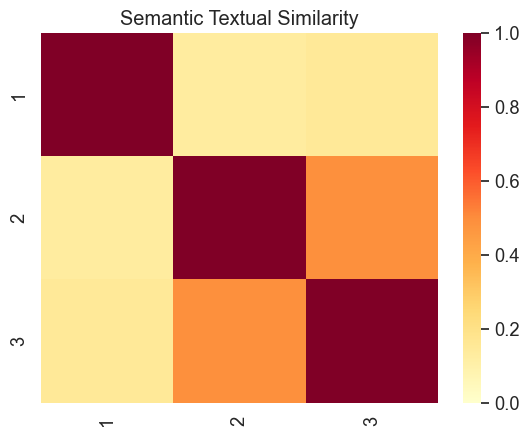

In [189]:
messages = [text_embeddings[2], text_embeddings[43], text_embeddings[42]]
plot_similarity([1,2,3],messages,90)

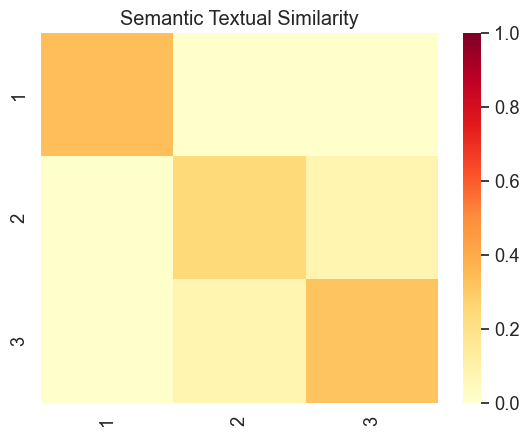

In [190]:
messages_debiased  = [projected_embeddings[2], projected_embeddings[43], projected_embeddings[42]]
plot_similarity([1,2,3],messages_debiased,90)

Manual debiasing by removing the biased words

In [191]:
sentence_1 = df_main['text'][2]
print(sentence_1)

sentence_1d = 'A year after a Democratic wave swept an unprecedented number of women and people of color into higher office all across America, and at a time when Trump’s approval rating is _, women should not be afraid of nominating another woman to drive Trump and his brand of patriarchy out of the Oval Office.'

A year after a Democratic wave swept an unprecedented number of women and people of color into higher office all across America, and at a time when Trump’s approval rating is cratering, women should not be afraid of nominating another woman to drive Trump and his brand of pig-headed patriarchy out of the Oval Office.


In [192]:
sentence_2 = df_main['text'][43]
print(sentence_2)
sentence_2d = 'Borrowing from Hillary Clinton, Italian media have labeled those attending the pro-family Congress a “list of deplorables,” calling pro-life and pro-family advocates “neofascists” and “homophobes.”'

Borrowing from Hillary Clinton, leftist Italian media have labeled those attending the pro-family Congress a “list of deplorables,” calling pro-life and pro-family advocates “neofascists” and “homophobes.”


In [193]:
sentence_3 = df_main['text'][42]
print(sentence_3)

The Roman Catholic Church allows only men to be ordained as priests and women have traditionally been consigned to the shadows of its administration.


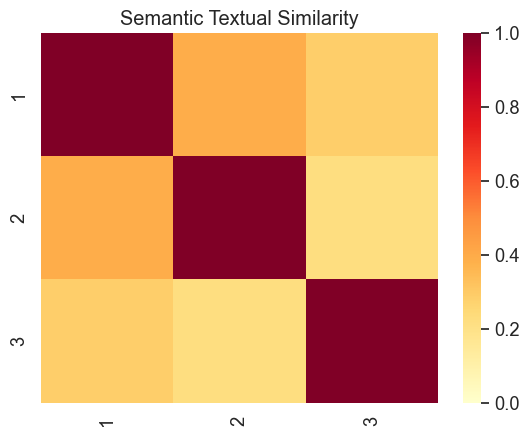

In [194]:
messages_manual_debias = [sentence_1d, sentence_2d, sentence_3]
run_and_plot(messages_manual_debias)